In [77]:
using Distributions
mu_1 = 20.0
sig_1 = 2#sqrt(4.0)
mu_2 = 18.0
sig_2 = 3#sqrt(9.0)
beta = 1#sqrt(1.0)

f_1(s1::Int) = pdf(Normal(mu_1, sig_1), s1)
f_2(s1::Int, p1::Int) = pdf(Normal(s1, beta), p1)
f_3(s2::Int) = pdf(Normal(mu_2, sig_2), s2)
f_4(s2::Int, p2::Int) = pdf(Normal(s2, beta), p2)
f_5(p1::Int, p2::Int, d::Int) = (p1 - p2 == d) ? 1.0 : 0.0 
f_6(d::Int) = if d > 0 ? 1.0 : 0.0 end

f_6 (generic function with 1 method)

In [4]:
# marginalization for s1

function marginalize_s1(N::Int, s1::Int)
    sum = 0.0
    for s2 in 1:N
        inner_sum_s2 = 0.0
        for p1 in 1:N
            inner_sum_p1 = 0.0
            for p2 in 1:p1 # its not wrong
                inner_sum_p1 += f_4(s2, p2)
            end
            inner_sum_p1 *= f_2(s1, p1)
            inner_sum_s2 += inner_sum_p1
        end
        inner_sum_s2 *= f_3(s2)
        sum += inner_sum_s2
    end
    return sum * f_1(s1)
end

marginalize_s1 (generic function with 1 method)

In [5]:
# marginalization for s1

function marginalize_s2(N::Int, s2::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s1 = 0.0
        for p1 in 1:N
            inner_sum_p1 = 0.0
            for p2 in 1:p1 # its not wrong
                inner_sum_p1 += f_4(s2, p2)
            end
            inner_sum_p1 *= f_2(s1, p1)
            inner_sum_s1 += inner_sum_p1
        end
        inner_sum_s1 *= f_1(s2)
        sum += inner_sum_s1
    end
    return sum * f_3(s2)
end

marginalize_s2 (generic function with 1 method)

In [6]:
function marginalize_p1(N::Int, p1::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2= 0.0
        for s2 in 1:N
            inner_sum_p2 = 0.0
            for p2 in 1:p1
                inner_sum_s2 += f_4(s2, p2)
            end
            inner_sum_s2 += (f_3(s2) * inner_sum_s2)
        end
        sum += (f_1(s1) * f_2(s1,p1) * inner_sum_s2) 
    end
    return sum
end

marginalize_p1 (generic function with 1 method)

In [7]:
function marginalize_p2(N::Int, p2::Int)
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2 = 0.0
        for s2 in 1:N
            inner_sum_p1 = 0.0
            for p1 in p2:N
                inner_sum_p1 += f_2(s1, p1)
            end
            inner_sum_s2 += (f_3(s2) * f_4(s2, p2))
        end
        sum += (inner_sum_s2 * f_1(s1))
    end
    return sum
end

marginalize_p2 (generic function with 1 method)

In [8]:
function marginalize_d(N::Int, d::Int)
    if d <= 0
        return 0.0
    end
    sum = 0.0
    for s1 in 1:N
        inner_sum_s2 = 0.0
        for s2 in 1:N
            inner_sum_p1 =0.0
            for p1 in d:N
                inner_sum_p1 += f_2(s1, p1) * f_4(s2, p1 - d)
            end
            inner_sum_s2 += (inner_sum_p1 * f_3(s2))
        end
        sum = f_1(s1) * inner_sum_s2
    end
    return sum
end

marginalize_d (generic function with 1 method)

In [9]:
#forward
function_mf1_s1(s1::Int) = f_1(s1)
function_mf3_s2(s2::Int) = f_3(s2)
function_f_p_s1(s1::Int) = function_mf1_s1(s1) 
function_f_p_s2(s2::Int) = function_mf3_s2(s2)
function_mf2_p1(N::Int, p1::Int) = sum([f_2(s1, p1) * function_f_p_s1(s1) for s1 in 1:N])
function_mf4_p2(N::Int, p2::Int) = sum([f_4(s2, p2) * function_f_p_s2(s2) for s2 in 1:N])
function_f_p_p1(N::Int, p1::Int) = function_mf2_p1(N, p1) 
function_f_p_p2(N::Int, p2::Int) = function_mf4_p2(N, p2)
function_mp1_f5(N::Int, p1::Int) = function_f_p_p1(N, p1)
function_mp2_f5(N::Int, p2::Int) = function_f_p_p2(N, p2)
function_mf5_d(N::Int, d::Int) = sum((f_5(p1, p1 - d, d) *  function_mp1_f5(N,p1) * function_mp2_f5(N,p1 - d)) for p1 in d:N)
function_f_p_d(N::Int, d::Int) = function_mf5_d(N,d)

#backward
#observer d = 1
function_mf6_d(d::Int) = (d > 0.0) ? 1.0 : 0.0
function_p_d(N::Int, d::Int) = function_mf6_d(d) > 0.0 ? function_mf5_d(N,d) : 0.0
function_md_f5(N::Int, d::Int) = (function_mf5_d(N, d) > 0.0 )  ? (function_p_d(N, d) / function_mf5_d(N, d)) : 0.0
function_mf5_p1(N::Int, p1::Int) = sum((function_md_f5(N, d) *  function_mp2_f5(N, p1 - d)) for d in 1:N) # d = p1 - p2, p2 = p1 - d
function_mf5_p2(N::Int, p2::Int) = sum((function_md_f5(N, d) *  function_mp1_f5(N, p2 + d)) for d in 1:N) # p1 = p2 + d
function_p_p1(N::Int, p1::Int ) = function_mf2_p1(N, p1) * function_mf5_p1(N, p1) # sum()
function_p_p2(N::Int, p2::Int ) = function_mf4_p2(N, p2) * function_mf5_p2(N, p2)
function_mf2_s1(N::Int, s1::Int) = sum( ( f_2(s1, p1) * (function_p_p1(N,p1) / function_mf2_p1(N, p1)) ) for p1 in 1:N)
function_mf4_s2(N::Int, s2::Int) = sum( ( f_4(s2, p2) * (function_p_p2(N,p2) / function_mf4_p2(N, p2)) ) for p2 in 1:N)
function_p_s1(N::Int, s1::Int) = function_mf1_s1(s1) * function_mf2_s1(N,s1)
function_p_s2(N::Int, s2::Int) = function_mf3_s2(s2) * function_mf4_s2(N, s2)


function_p_s2 (generic function with 1 method)

In [34]:
# calculating using vector
#forward

function calculateAllMarginalsViaMsg(N::Int=20)
    #N = 20
    mf1_s1 = [f_1(s1) for s1 in 1:N]
    mf3_s2 = [f_3(s2) for s2 in 1:N]
    f_p_s1 = copy(mf1_s1)
    f_p_s2 = copy(mf3_s2)
    mf2_p1 = [sum([f_2(s1, p1) * f_p_s1[s1] for s1 in 1:N]) for p1 in 1:N]
    mf4_p2 = [sum([f_4(s2, p2) * f_p_s2[s2] for s2 in 1:N]) for p2 in 1:N]
    f_p_p1 = copy( mf2_p1 )
    f_p_p2 = copy(mf4_p2)
    mp1_f5 = copy(f_p_p1)
    mp2_f5 = copy(f_p_p2)
    mf5_d = [sum([f_5(p1, p1 - d, d) *  mp1_f5[p1] * mp2_f5[p1 - d] for p1 in max(d + 1,1): min(N,N + d) ];init = 0.0) for d in -N:N]
    f_p_d = copy(mf5_d)

    #backward
    #observer d = 1
    mf6_d = [(d > 0.0) ? 1.0 : 0.0 for d in -N:N]
    p_d =  [ mf6_d[d + N + 1] > 0.0 ? mf5_d[d+ N + 1] : 0.0 for d in -N:N]
    md_f5 = [(mf5_d[d + N + 1] > 0.0 ) ? (p_d[d + N + 1] / mf5_d[d + N + 1]) : 0.0 for d in -N:N]
    mf5_p1 = [sum([md_f5[d+N+1] * mp2_f5[p1 - d] for d in 1:(p1-1)]; init=0.0) for p1 in 1:N]
    mf5_p2 = [ sum([md_f5[d + N + 1 ] *  mp1_f5[p2 + d] for d in 1:(N - p2)]; init = 0.0) for p2 in 1:N ] # p2 + d = p1 / p1 in 1:N -> d 1:N-p2 
    p_p1 = [ (mf2_p1[p1] * mf5_p1[p1]) for p1 in 1:N]
    p_p2 = [ (mf4_p2[p2] * mf5_p2[p2]) for p2 in 1:N]
    mf2_s1 = [ sum([ f_2(s1, p1) * (p_p1[p1] / mf2_p1[p1]) for p1 in 1:N ]) for s1 in 1:N ]
    mf4_s2 = [sum([  f_4(s2, p2) * (p_p2[p2] / mf4_p2[p2]) for p2 in 1:N]) for s2 in 1:N]
    p_s1 = [mf1_s1[s1] * mf2_s1[s1] for s1 in 1:N]
    p_s2 = [mf3_s2[s2] * mf4_s2[s2] for s2 in 1:N]

    return (p_s1, p_s2, p_p1, p_p2, p_d)
end


calculateAllMarginalsViaMsg (generic function with 3 methods)

In [40]:
function_p_s1(20, 8)

0.015479075142743562

In [38]:
marginalize_s1(20,8)

0.03011650250443023

In [48]:
p_s1, p_s2, p_p1, p_p2, p_d = calculateAllMarginalsViaMsg()

([2.94136204902952e-11, 3.3091556763448183e-9, 2.0003608506208073e-7, 6.510681273144378e-6, 0.0001142766652288764, 0.0010834677315604128, 0.005559759514291236, 0.015479044623497744, 0.023454755731912, 0.019419414167122638, 0.008829813236613256, 0.0022189928498590134, 0.0003106875317299469, 2.4472131410696813e-5, 1.0963956987323903e-6, 2.822267630099741e-8, 4.1882461167705484e-10, 3.5380350451404045e-12, 1.6440501632879904e-14, 4.0001167323941526e-17], [1.2433702695580425e-14, 3.0749122243278523e-12, 3.9556071702102667e-10, 2.771480319072429e-8, 1.0915772369383887e-6, 2.445226609834744e-5, 0.0003106519809949374, 0.0022189656345265344, 0.008829806807992736, 0.019419423106674247, 0.023454777491353683, 0.015479072673902774, 0.005559781360420571, 0.001083478045063023, 0.00011427960953829765, 6.511184694361758e-6, 2.0008636205276457e-7, 3.31196037569514e-9, 2.949619834706995e-11, 1.4115300110420243e-13], [0.0, 4.835333404792939e-9, 1.3314919541778594e-7, 2.2782084128551277e-6, 2.609081544998

In [49]:
p_s1

20-element Vector{Float64}:
 2.94136204902952e-11
 3.3091556763448183e-9
 2.0003608506208073e-7
 6.510681273144378e-6
 0.0001142766652288764
 0.0010834677315604128
 0.005559759514291236
 0.015479044623497744
 0.023454755731912
 0.019419414167122638
 0.008829813236613256
 0.0022189928498590134
 0.0003106875317299469
 2.4472131410696813e-5
 1.0963956987323903e-6
 2.822267630099741e-8
 4.1882461167705484e-10
 3.5380350451404045e-12
 1.6440501632879904e-14
 4.0001167323941526e-17

In [27]:
p_s1[8]

0.015479044623497744

In [28]:
function calculateAllMarginals()
    N = 20
    for i in 1:N marginalize_s1(20, i) end
    for i in 1:N marginalize_s2(20, i) end
    for i in 1:N marginalize_p1(20, i) end
    for i in 1:N marginalize_p2(20, i) end
    for i in -N:N marginalize_d(20, i) end
end

calculateAllMarginals (generic function with 1 method)

In [30]:
using BenchmarkTools
t1 = @belapsed calculateAllMarginalsViaMsg()
t2 = @belapsed calculateAllMarginals()

println("ViaMsg: $t1 seconds")
println("Direct: $t2 seconds")
println("Speedup: ", t2 / t1, "× (ViaMsg vs Direct)")

ViaMsg: 0.000307917 seconds
Direct: 0.097595833 seconds
Speedup: 316.95500086062157× (ViaMsg vs Direct)


In [53]:
for i in 15:40
    println("iteration $i")
    println(marginalize_s1(i,8))
    p_s1, p_s2, p_p1, p_p2, p_d= calculateAllMarginalsViaMsg(i)
    println(length(p_s1))
end

iteration 15
0.03011340368982501
15
iteration 16
0.030116373185878512
16
iteration 17
0.030116498175503895
17
iteration 18
0.030116502385620435
18
iteration 19
0.030116502501967287
19
iteration 20
0.03011650250443023
20
iteration 21
0.03011650250446828
21
iteration 22
0.0301165025044687
22
iteration 23
0.030116502504468703
23
iteration 24
0.030116502504468703
24
iteration 25
0.030116502504468703
25
iteration 26
0.030116502504468703
26
iteration 27
0.030116502504468703
27
iteration 28
0.030116502504468703
28
iteration 29
0.030116502504468703
29
iteration 30
0.030116502504468703
30
iteration 31
0.030116502504468703
31
iteration 32
0.030116502504468703
32
iteration 33
0.030116502504468703
33
iteration 34
0.030116502504468703
34
iteration 35
0.030116502504468703
35
iteration 36
0.030116502504468703
36
iteration 37
0.030116502504468703
37
iteration 38
0.030116502504468703
38
iteration 39
0.030116502504468703
39
iteration 40
0.030116502504468703
40


In [79]:
p_s1, p_s2, p_p1, p_p2, p_d = calculateAllMarginalsViaMsg(40)

([2.4600893127459502e-28, 1.454110817527577e-25, 5.492933573286421e-23, 1.4388702659192867e-20, 2.6720420574772457e-18, 3.53609957831697e-16, 3.339977512438333e-14, 2.2535662642585544e-12, 1.0870353112298785e-10, 3.75183385475212e-9  …  5.384463020877405e-8, 3.037874677914943e-9, 1.3347706805032234e-10, 4.5673539779079795e-12, 1.217159893928908e-13, 2.526131612103383e-15, 4.0825652168964107e-17, 5.116412013762447e-19, 4.743895114359524e-21, 2.691074823269497e-23], [9.901920470147574e-9, 8.335846141679286e-8, 4.933098092294586e-7, 2.4816794427038294e-6, 1.1123604298105772e-5, 4.461007481854847e-5, 0.00016009019666613612, 0.0005140924183571474, 0.0014772710862310434, 0.0037984831656671975  …  1.2677507285150495e-11, 3.449993575963992e-13, 7.13574390156354e-15, 1.12109747092034e-16, 1.3372854762128373e-18, 1.2106322459217264e-20, 8.315115578534144e-23, 4.331883804113883e-25, 1.711331638773126e-27, 5.123609591524361e-30], [0.0, 1.0054316323228299e-22, 2.0792470380470002e-20, 2.795157815867

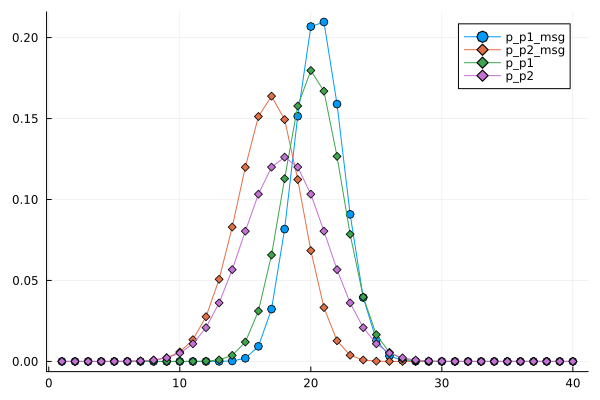

In [82]:
using Plots

# (Optional but often helpful in Jupyter)
gr()   # choose GR backend

# x values
xs = 1:40

# your first function
ys1 = p_s1#[marginalize_s1(20, i) for i in xs]

# your comparison vector (must already be defined!)
# make sure it has length 20:
@assert length(p_s1) == 40 "p_s1 must have length 20"

ys2 = p_s2 # or p_s1[1:20] if it's longer
ys3 = [marginalize_p1(40, i) for i in xs]
ys4 = [marginalize_p2(40, i) for i in xs]

ys1_norm = ys1 / sum(ys1)
ys2_norm = ys2 / sum(ys2)
ys3_norm = ys3 / sum(ys3)
ys4_norm = ys4 / sum(ys4)

# build the plot object
plt = plot(xs, ys1_norm,
           label = "p_p1_msg",
           marker = :o)

plot!(plt, xs, ys2_norm,
      label = "p_p2_msg",
      marker = :diamond)
plot!(plt, xs, ys3_norm,
      label = "p_p1",
      marker = :diamond)
plot!(plt, xs, ys4_norm,
      label = "p_p2",
      marker = :diamond)
# In Jupyter, explicitly display the plot:
display(plt)


In [ ]:
y_norm[9]

0.018087812697890407

In [91]:
p_p2[17] - p_p2[19]

0.033724411070596594

In [76]:
[marginalize_p1(20, i) for i in xs]

20-element Vector{Float64}:
 0.0020369788091420143
 0.017317505856582354
 0.0859114455520396
 0.2992653401695008
 0.7826133129274404
 1.587727277724696
 2.5431729579656195
 3.247212535821729
 3.321706400237296
 2.7288242896671577
 1.8027881110309847
 0.95934450424907
 0.41228017602919576
 0.14357337458584074
 0.0406543394413966
 0.009385170648881436
 0.001768807347356971
 0.0002721335729170494
 3.4129789072505e-5
 3.4830248514148725e-6